# Gradient Descent Pricing with Uber Data

Data source: https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset?resource=download

This code uses the Gradient Descent for Dynamic Pricing and applies it to the data on Uber rides (1000 rows, historical cost of the ride as dependent variable)


## Objective 

The purpose of this document is showcasing dynamic pricing approaches for economic agents, and contrast their profit maximization ability with static pricing approaches as dictated by standard microeconomic theory.

It displays the methods and advantages of dynamic pricing by applying this method to Uber rides data and comparing the proft maximizing ability of static and dynamic pricing methods.

## Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
from autograd import value_and_grad
import matplotlib.pyplot as plt
from modules.preprocessing import simple_preprocessing
from modules.util import intercept_reshaped_train_test
from modules.config import LEARNING_RATE_GD, MAX_ITERATIONS

preprocessor, X, y, categorical_features, numerical_features = simple_preprocessing()
X_train, X_test, y_train, y_test = intercept_reshaped_train_test(X, y, preprocessor)


## Functions 

### 1. model function

Computes the predicted values (y_pred) using the dot product of the feature matrix x and the weight vector w.
* x[0].T: Transposes the feature matrix x and accesses the first element because x is wrapped in an additional dimension.
* w: The weight vector.
* np.dot(x[0].T, w): Performs the dot product, resulting in the predicted values.



### 2. least_squares function
Calculates the cost as the sum of squared differences between the predicted values (model(w, x)) and the actual values (y).
* model(w, x): Calls the model function to get the predicted values.
* (model(w, x) - y): Computes the difference between predicted and actual values.
* (model(w, x) - y) ** 2: Squares each difference to penalize larger errors more.
* np.sum(...): Sums all the squared differences to get the total cost.

### 3. gradient_descent function

Minimizes the cost function using gradient descent.

#### Parameters:
* g: The cost function to be minimized.
* alpha: The learning rate, controlling the size of the weight updates.
* max_its: The maximum number of iterations.
* w: The initial weights.
* x: The feature matrix.
* y: The target values.

#### Process:
* value_and_grad(g): Creates a function that returns both the value of the cost function and its gradient with respect to the weights.
* cost_eval, grad_eval = gradient(w, x, y): Evaluates the cost and its gradient at the current weights.
* w = w - alpha * grad_eval: Updates the weights by moving in the direction of the negative gradient scaled by the learning rate.
* weight_history.append(w): Stores the weights after each update.
* cost_history.append(cost_eval): Stores the cost after each update.

In [4]:
def model(w, x):
    return np.dot(x[0].T, w)

def least_squares(w, x, y):
    cost = np.sum((model(w, x) - y) ** 2)
    return cost

def gradient_descent(g, alpha, max_its, w, x, y):
    gradient = value_and_grad(g)
    weight_history = []
    cost_history = []
    for k in range(1, max_its + 1):
        cost_eval, grad_eval = gradient(w, x, y)
        weight_history.append(w)
        cost_history.append(cost_eval)
        w = w - alpha * grad_eval
    weight_history.append(w)
    cost_history.append(g(w, x, y))
    cost_history = np.asarray(cost_history) / x.shape[2]
    return weight_history, cost_history


## Training 

gradient_descent(least_squares, rate, max_it, initial_weights, X_train, y_train): Runs the gradient descent to minimize the least squares cost function, returning the history of weights (wh) and costs (ch).

### Finding Optimal Weights

np.argmin(ch): Finds the index of the minimum cost in the cost history.
wh[index]: Retrieves the weights corresponding to the minimum cost.

In [ ]:
initial_weights = np.random.rand(X_train.shape[1])
wh, ch = gradient_descent(least_squares, LEARNING_RATE_GD, MAX_ITERATIONS, initial_weights, X_train, y_train)
index = np.argmin(ch)
w_star = wh[index]

#### Training Cost

cost_train = ch[index] retrieves the training cost at the optimal weights.

#### Test Cost

cost_test = least_squares(w_star, X_test, y_test) / X_test.shape[2] computes the test cost using the optimal weights and normalizes it by the number of test samples. 

This value assesses the model's performance on new data. It is crucial for evaluating the model's ability to generalize. A significant difference between the training cost and the test cost may indicate overfitting or underfitting.
Overfitting: The model performs well on the training data but poorly on the test data, suggesting it has learned noise or specific patterns in the training set that do not generalize.

In [6]:
cost_train = ch[index]
cost_test = least_squares(w_star, X_test, y_test) / X_test.shape[2]

## Calculations


### demand curve()

Calculates the demand curve based on the given axis (array of price points) and value (array of historical costs of rides).
For each price in axis, it counts how many values in value are greater than or equal to that price, then divides by the sample size to get a proportion (demand) for that price point.

This helps us calculate the APP for Static Pricing 

In [7]:

def demand_curve(axis, value):
    demand = []
    sample_size = len(value)
    for price in axis:
        demand.append(sum(1 if x >= price else 0 for x in value) / sample_size)
    return demand

def APP_s(axis, value, c):
    demand = demand_curve(axis, value)
    app_s = []
    for i in range(len(axis)):
        app_s.append(max(axis[i] - c, 0) * demand[i])
    return app_s

def APP_d(w, x, y, c, d):
    est = d * model(w, x)
    ind = list(range(len(est)))
    rev = sum(max(est[i], c) if y[0][i] >= max(est[i], c) else 0 for i in ind)
    return rev / x.shape[2]

c = 0  #cost 0 since we do not have the information
axis_2 = np.linspace(0, int(np.round(np.max(y_train), 0) + 1), int(2 * (np.round(np.max(y_train), 0) + 1)))
app_s_train = APP_s(axis_2, y_train[0], c)
index = np.argmax(app_s_train)
app_s_test = APP_s(axis_2, y_test[0], c)
app_s_star = app_s_test[index]

## Application and Display of Results
We will compare the baseline method of static price maximization with the alternative approach of dynamic price maximization. Both methods will be provided a fraction, *train_ratio*, of the generated data to develop an optimal pricing mechanism. This will then be tested with the remaining fraction of data, where the algorithm will be given characteristical information ($x_{i,1},...,x_{i,4}$) but not valuation information ($p_i$) for each consumer $i$, and will be tasked with suggesting a price to charge each consumer to maximize its revenue.

### Static Pricing

In static pricing, a single fixed price is determined that maximizes profit across all sales. This price does not change based on individual circumstances or varying demand conditions.


We train the static pricing algorithm as governed by microeconomic theory. That is, we select the static price, $p^*$, that maximizes,
<center> $\pi(p) = (p-c)*q_d(p)$ </center>
<br>
where $c$ is given by the hyperparameter *c*, the variable cost of producing the good. Throughout this document, profit is given as average profit per person (APP), and is calculated by summing the profits across the population and dividing by the total population of consumers. A plot of profit vs. price for static price profit maximization is given below. Profit DOES NOT account for cost (that is not available) for simplicity. If made available, it can be assigned as c value, or according to journey length, which would be closer to real life. 


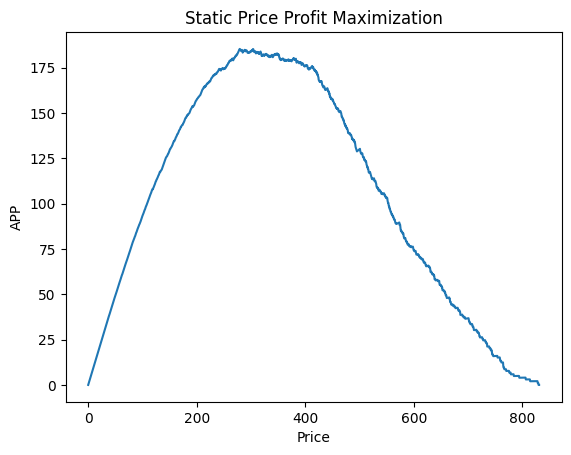

Optimized Static APP: 182.86
This represents the maximum average price per unit (APP) that can be  achieved using a static pricing strategy. Here, the price is fixed and does  not vary with demand or other factors.
Optimized Price: 279.16797110174593
This is the optimal static price that maximizes the APP.


In [8]:
plt.figure()
plt.plot(axis_2, app_s_train)
plt.xlabel('Price')
plt.ylabel('APP')
plt.title('Static Price Profit Maximization')
plt.show()


print('Optimized Static APP: {:.2f}'.format(app_s_star))
print ('This represents the maximum average price per unit (APP) that can be '
' achieved using a static pricing strategy. Here, the price is fixed and does '
' not vary with demand or other factors.')
print('Optimized Price:', axis_2[index])
print('This is the optimal static price that maximizes the APP.')




### Dynamic Pricing

In dynamic pricing, the price for each unit is adjusted based on a model's prediction that takes into account various factors such as demand, time, customer loyalty, and other features. This allows for more flexible and potentially more profitable pricing.

#### Optimized Discount Factor

The discount factor 0.x suggests that, on average, the optimal price to charge is x% of the model's predicted price for each ride. This factor adjusts the price downward to maximize overall profit.

#### Dynamic APP Calculation

The dynamic APP is calculated by applying this discount to the predicted prices and summing the resulting revenues, ensuring the adjusted price does not fall below a minimum cost.

We train an automatic controller to predict $p_i$, the value each person $i$ assigns the good, based on her characteristics $x_{i,1},...,x_{i,4}$. Note that we do not give the algorithm any information on how $p_i$ is drawn.

The automatic controller employs gradient descent to minimize a cost function. In this case, the cost function we will employ is given by,
<center>$L(\vec{w}) = \sum_{i=1}^{train\_size} (\vec{w}^T*\vec{x}_i - p_i)^2$</center>
<br>
We attempt to find the weight vector $\vec{w}^*$ which, when multiplied by any characteristic vector $\vec{x}_i$, minimizes the average difference between our predicted value for consumer $i$ ($\hat{p}_i = \vec{w}^T*\vec{x}_i$) and the true value $p_i$. This is the intuition behind the cost function.


We train the automatic controller with cost function $L$, and learning rate *rate* for *max_it* iterations. The cost history plot is depicted on the Dynamic Price Profit Maximisation plot below. 




#### Optimized Weights


The best weights found by gradient descent. The values of these weights tell you how much each feature contributes to the prediction. For example, a higher positive weight means that the corresponding feature has a strong positive influence on the target variable, while a negative weight means a strong negative influence.




#### Optimized Cost

The minimized training cost.

This value shows how well the model fits the training data. A lower value indicates a better fit, meaning the model's predictions are close to the actual values in the training set.


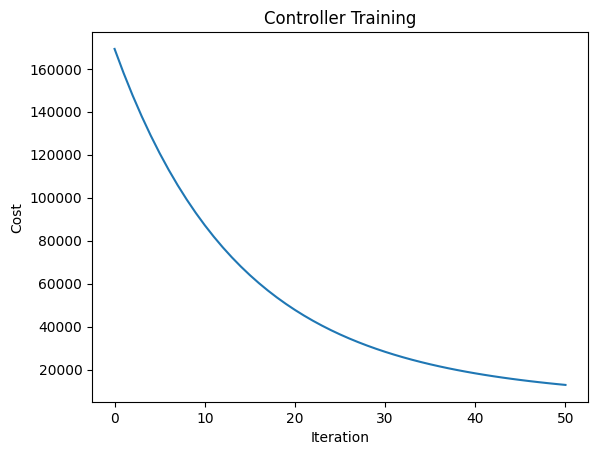

Optimized Weights:
Intercept: 131.5
Number_of_Riders: 0.5
Number_of_Drivers: 4.0
Number_of_Past_Rides: 3.3
Average_Ratings: -0.3
Expected_Ride_Duration: 95.9
Location_Category_Rural: 43.3
Location_Category_Suburban: 44.1
Location_Category_Urban: 44.7
Customer_Loyalty_Status_Gold: 42.2
Customer_Loyalty_Status_Regular: 43.1
Customer_Loyalty_Status_Silver: 47.1
Time_of_Booking_Afternoon: 32.6
Time_of_Booking_Evening: 30.6
Time_of_Booking_Morning: 33.8
Time_of_Booking_Night: 36.2
Vehicle_Type_Economy: 55.7
Vehicle_Type_Premium: 76.5
Optimized Weights:  [131.5   0.5   4.    3.3  -0.3  95.9  43.3  44.1  44.7  42.2  43.1  47.1
  32.6  30.6  33.8  36.2  55.7  76.5]
Optimized Cost: 12869.84
This is the cost (or error) associated with the optimized weights on the training dataset. It represents the sum of squared differences between the predicted and actual historical costs of rides, divided by the number of observations.
Test Cost: 13782.37
This is the cost (or error) when the optimized model i

In [9]:

plt.figure()
plt.plot(range(max_it + 1), ch)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Controller Training')
plt.show()

#feature names visibility
categorical_transformer = preprocessor.transformers_[1][1]  # Get the OneHotEncoder from the ColumnTransformer
feature_names_categorical = list(categorical_transformer.get_feature_names_out(input_features=categorical_features))
feature_names = numerical_features + feature_names_categorical
feature_names = ['Intercept'] + feature_names

print('Optimized Weights:')
for feature, weight in zip(feature_names, np.round(w_star, 1)):
    print(f'{feature}: {weight}')




print('Optimized Weights: ', np.round(w_star, 1))
print('Optimized Cost: {:.2f}'.format(cost_train))
print('This is the cost (or error) associated with the optimized weights on the'
      ' training dataset. It represents the sum of squared differences between '
      'the predicted and actual historical costs of rides, divided by the '
      'number of observations.')
print('Test Cost: {:.2f}'.format(cost_test))
print('This is the cost (or error) when the optimized model is applied to the'
      ' test dataset. The slightly higher test cost compared to the training '
      'cost indicates how well the model generalizes to unseen data.')

app_d_1 = APP_d(w_star, X_test, y_test, c, 1)
print('Dynamic APP: {:.2f}'.format(app_d_1))
print('This is the average price per unit (APP) achieved using the dynamic '
'pricing strategy without any discount.')






#### Explanation of Discount Factors and Corresponding APPs

* axis_d: Defines a range of discount factors (d) for dynamic pricing evaluation.
* app_d: Computes the APP for each discount factor in axis_d based on test data (X_test, y_test).
* d_star: Identifies the discount factor that maximizes the APP (app_d).
* app_d_star: Calculates the APP using the optimal discount factor (d_star) on training data (X_train, y_train).


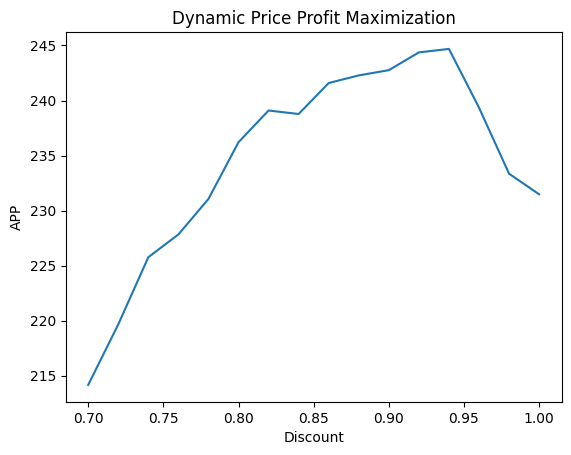

Optimized Discount: 0.94
Applying this discount factor helps to better align prices with what customers are willing to pay, maximizing demand and revenue.
Test Dynamic APP: 244.69
This is the average price per unit (APP) achieved using the dynamic pricing strategy with the optimized discount factor on the test dataset.


In [10]:
axis_d = np.linspace(0.7, 1, 16)
app_d = [APP_d(w_star, X_test, y_test, c, d) for d in axis_d]

d_star = axis_d[np.argmax(app_d)]
app_d_star = APP_d(w_star, X_test, y_test, c, d_star)



plt.figure()
plt.plot(axis_d, app_d)
plt.xlabel('Discount')
plt.ylabel('APP')
plt.title('Dynamic Price Profit Maximization')
plt.show()


print('Optimized Discount: {:.2f}'.format(d_star))
print('Applying this discount factor helps to better align prices with what '
'customers are willing to pay, maximizing demand and revenue.')
print('Test Dynamic APP: {:.2f}'.format(app_d_star))
print('This is the average price per unit (APP) achieved using the dynamic '
'pricing strategy with the optimized discount factor on the test dataset.')





In [11]:
print('Dynamic APPU (Test-based): {:.2f}'.format(app_d_star))
print('Static APPU (Test-based): {:.2f}'.format(app_s_star))
print('Percentage in Profit Increase: {:.2%}'.format((app_d_star - app_s_star) / app_s_star))


Dynamic APPU (Test-based): 244.69
Static APPU (Test-based): 182.86
Percentage in Profit Increase: 33.81%


## Recap

### Average Price Per Unit (APP) for Static Pricing

* Purpose: Calculates the APP for each price point. It considers the demand at each price and subtracts the cost c to find the profit per unit.

### APP for Dynamic Pricing

* Purpose: Calculates the APP for dynamic pricing. The price is estimated using the model's weights w and features x, scaled by a discount factor d.
* Output: Average Price Per unit for the given discount factor d.


### Finding the Optimal Discount Factor

app_d_1 = APP_d(w_star, X_test, y_test, c, 1)
axis_d = np.linspace(0.7, 1, 16)
app_d = [APP_d(w_star, X_test, y_test, c, d) for d in axis_d]

d_star = axis_d[np.argmax(app_d)]
app_d_star = APP_d(w_star, X_train, y_train, c, d_star)

* Purpose: Finds the discount factor d that maximizes the APP using the test data.


#### Dynamic APPU (Test-based)

The APP for dynamic pricing using the optimal discount factor.

#### Static APPU (Test-based)

The APP for static pricing using the optimal static price.

#### Percentage in Profit Increase

The percentage increase in profit from using dynamic pricing over static pricing.

## Predicting Prices

For each ride, the model calculates a predicted price based on the features of that ride. This includes numerical features like the number of riders, drivers, past rides, average ratings, and expected ride duration, as well as categorical features like location category, customer loyalty status, time of booking, and vehicle type.
These features are preprocessed using standard scaling for numerical features and one-hot encoding for categorical features.


## Optimization and Discount Application:

The model has been trained to minimize the cost function, leading to the optimal set of weights (w_star).
The predicted price (predicted_price) is the result of the dot product of the features and these optimized weights.
The optimized discount factor is then applied to the predicted price to arrive at the final dynamic price.

The reason the discounted Test Dynamic APP is higher than the Dynamic APP without discount is due to the increase in demand more than compensating for the price reduction, leading to an overall increase in average revenue per ride. This demonstrates the effectiveness of the dynamic pricing strategy with the optimized discount factor.